In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



def gen_gaussian_kernel(kernel_size=9, sigma=2.0):
    # Generate 1D Gaussian kernel
    kernel_1d = cv2.getGaussianKernel(kernel_size, sigma)
    
    # Convert 1D kernel to 2D by performing outer product
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    
    return kernel_2d

def mse_metric(blurred_image, ref_gaussian_img, threshold=1.0):
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((blurred_image - ref_gaussian_img) ** 2)

    # Check if images are approximately the same based on MSE
    if mse < threshold:
        print(f"The blurred images are approximately the same with mse:{mse}")
    else:
        print(f"The blurred images are different with mse:{mse}")

def ssim_metric(img1, img2, L=255, threshold = 0.8):
    # Constants for stability
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    # Mean of images
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)

    # Variance of images
    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)

    # Covariance of images
    sigma12 = np.mean((img1 - mu1) * (img2 - mu2))

    # SSIM formula
    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_val = numerator / denominator

    # Check if images are approximately the same based on MSE
    if ssim_val > threshold:
        print(f"The blurred images are approximately the same with ssim_val:{ssim_val}")
    else:
        print(f"The blurred images are different with ssim_val:{ssim_val}")





latency:0.12760713338851928
im2col out: (157, 279, 3)


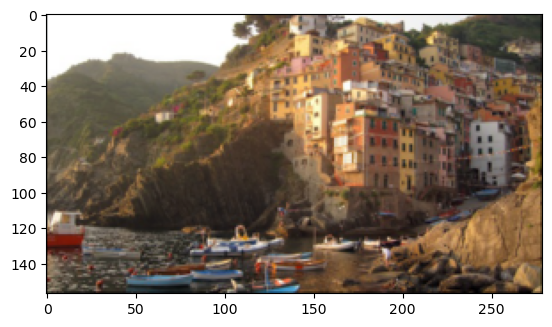

In [2]:

"""
3 elements to it 
1. simple convolve function which will give the previous image as it is 
1.1 might need padding
2. add stride capabilities 
3. make it uneven kernel 
3.1 odd kernel shapes q
3.2 think about even kernel shapes
4. make it use im2col functionalities 
5. implement the same in CUDA kernel
6. better if I can make that python compatible
"""

"""
for gaussian kernel 
1. generate the kernel of sigmax,sigmax and variance 
2 add padding
"""
def padd(img, kernel, padding=None):
    # out_shape = input_shape - kernel + 1 + 2p
    # p = kernel -1
    # padd_img_shape = input_shape + 2p
    if padding is None:
        padd_shape_0 = (kernel.shape[0] - 1) // 2 
        padd_shape_1 = (kernel.shape[1] - 1) // 2
    else:
        padd_shape_0 = padding[0]
        padd_shape_1 = padding[1]
    padd_img = np.zeros((img.shape[0] + 2*(padd_shape_0), img.shape[1] + 2*(padd_shape_1), img.shape[2]))
    padd_img[padd_shape_0:-padd_shape_0, padd_shape_1:-padd_shape_1, :] = img
    return padd_img, (padd_shape_0, padd_shape_1)


def convolve(img, kernel, padding=None, stride = 1):
    # out_shape = in_shape - kernel + 1 
    orig_img_shape = img.shape
    img, (px, py) = padd(img, kernel, padding=padding)
    output_shape = ((orig_img_shape[0] + 2*px - kernel.shape[0])//stride + 1, (orig_img_shape[1] + 2*py - kernel.shape[1])//stride + 1, img.shape[2])
    output = np.zeros(output_shape, dtype=kernel.dtype)
    
    """
    run based on the shape of the output or 
    run based on the input shape instead
    """
    kernel_3d = np.repeat(kernel[:,:,None],3, axis=2)
    for i in range (0, img.shape[0]-kernel_3d.shape[0] + 1,stride):
        for j in range(0, img.shape[1]- kernel_3d.shape[1] + 1,stride):
            img_subset = img[i:i+kernel_3d.shape[0], j:j+kernel_3d.shape[1]].astype(kernel_3d.dtype)
            value = np.sum(np.multiply(img_subset, kernel_3d),axis=(0,1))
            output[i//stride, j//stride,:] = value

    img_norm = (output - np.min(output,axis=(0,1)))/(np.max(output, axis= (0,1))- np.min(output, axis=(0,1)))*255

    # Clip the values to ensure they are in the range [0, 255]
    img_norm = np.clip(img_norm, 0, 255).astype(np.uint8)
    return img_norm




# Perform blur operation
img_path = "/home/ramu/Personal/cuda_tutorials/intro_to_parallel/blur_kernel/cinque_terre_small.jpg"
orig_img = cv2.imread(img_path)


kernel_x = 3
sigma_x = 2
gaussian_kernel = gen_gaussian_kernel(kernel_x, sigma_x)

ref_gaussian_img = cv2.GaussianBlur(orig_img, (kernel_x, kernel_x), sigma_x)
blurred_image = cv2.filter2D(orig_img, -1, gaussian_kernel)


# mse_metric(ref_gaussian_img, blurred_image, threshold = 0.01)
# ssim_metric(ref_gaussian_img, blurred_image, threshold = 0.99)
# plt.imshow(np.hstack([orig_img,ref_gaussian_img, blurred_image])[:,:,::-1])

debug_x = 255
debug_y = 260
width = 3
gaussian_kernel = gen_gaussian_kernel(kernel_x, sigma_x)


diff = 0
import time
for _ in range(100):
    start_time = time.time()
    out = convolve(orig_img, gaussian_kernel,stride=2)
    end_time = time.time()
    diff += end_time - start_time

print(f"latency:{diff/100}")
print(f"im2col out:",out.shape)
plt.imshow(out[:,:,::-1])


# print(f"img.shape:{orig_img.shape} , output.shape:{out.shape}")
# print(f"ref:{ref_gaussian_img[debug_x:debug_x+width,debug_y:debug_y+width,0]}")
# print(f"actual:{out[debug_x:debug_x+width,debug_y:debug_y+width,0]}")
# mse_metric(ref_gaussian_img, out, threshold = 0.01)
# ssim_metric(ref_gaussian_img, out, threshold = 0.99)
# np.max(np.hstack([ref_gaussian_img]))
# plt.imshow(np.hstack([out, ref_gaussian_img])[:,:,::-1])
# plt.imshow(out[:,:,::-1])


latency:0.06053743839263916
im2col out: (157, 279, 3)


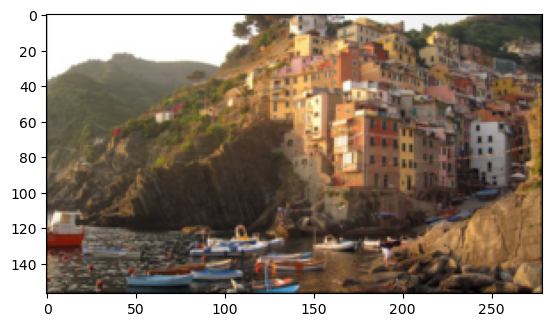

In [3]:
def im2col_convolve(img, kernel,padding=None,stride = 1):
    orig_image_shape = img.shape
    img, (px,py) = padd(img, kernel,padding=padding)
    out_shape_x = (orig_image_shape[0] + 2*px - kernel.shape[0])//stride + 1
    out_shape_y = (orig_image_shape[1] + 2*py - kernel.shape[1])//stride + 1
    
    output = np.zeros((out_shape_x, out_shape_y, orig_image_shape[2]))
    rows = []
    for i in range(0, img.shape[0] - kernel.shape[0] + 1, stride):
        for j in range(0, img.shape[1] - kernel.shape[1] + 1, stride):
            rows.append(img[i:i+kernel.shape[0], j:j+kernel.shape[1], :].reshape((-1,3)))
    rows = np.stack(rows,axis=0)
    kernel = np.repeat(kernel.flatten()[None,:,None],3,axis=2)
    result = np.sum(kernel * rows, axis=1, keepdims=True)
    result = result.reshape(output.shape[0], output.shape[1],3)
    result = (result - np.min(result,axis=(0,1)))/(np.max(result,axis=(0,1)) - np.min(result,axis=(0,1)))
    return result

diff = 0
import time
for _ in range(100):
    start_time = time.time()
    out_im2col = im2col_convolve(orig_img, gaussian_kernel, stride =2)
    end_time = time.time()
    diff += end_time - start_time

print(f"latency:{diff/100}")
print(f"im2col out:",out_im2col.shape)
plt.imshow(out_im2col[:,:,::-1])